## Analysis of US National Crash Fatalities for 2010 - 2015

Data sources: 
 - The crash data used in this analysis was obtained from the FARS dataset maintained by the NHTSA. A nation wide census of data related to fatal injuries suffered in motor vehicle traffic crashes.
 - 2010 - 2015 Population Census Data US government
 - USDA ERS - County level data
     - Unemployment and income
     - Educational attainment
     - 2010 - 2016 Population Estimates
 - US FPIS County and State Codes



### What is the question?

In 2015 the Obama Whitehouse posed a series of questions related to national traffic safety, and solicited answers to these questions. The FARS data was identified as a source of potential relavent data. The following is a list of these questions:

- <b>How might improving economic conditions around the country change how Americans are getting around? What models can we develop to identify communities that might be at a higher risk for fatal crashes?</b>

- How might climate change increase the risk of fatal crashes in a community?

- How might we use studies of attitudes toward speeding, distracted driving, and seat belt use to better target marketing and behavioral change campaigns?

- How might we monitor public health indicators and behavior risk indicators to target communities that might have a high prevalence of behaviors linked with fatal crashes (drinking, drug use/addiction, etc.)? What countermeasures should we create to address these issues?

#### For this notebook I will be focusing on the first question.


### How can we go about addressing the question?

In order to set the framework for a strategy, look at the question and decide on potentially relavent data to collect.

- List of Types of Data to Explore:
    - Traffic fatality data for communities around the US
    - Median income for these communities
    - Unemployment levels
    - Education levels for these communities
    - Vehicular mile of travel (VMT) for use in calculating a crash rate, if this data is not avaliable for each County, may need to use County population instead. VMT will be avaliable for states from FHWA, but this may be to course a measure. 
    - Metrics for urban or rural nature of Counties.
    - Economic typology of the Counties.
 

In [4]:
"""Import python libraries required"""
import pandas as pd
from dbfread import DBF
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import svm
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

from collections import defaultdict
import json
import matplotlib.cm as cm
import matplotlib as mpl

#Taken from Harvard CS109 homeworks
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

### Crash Data Processing

Access the NHTSA FARS Data for 2010 - 2015, then figure out pertinant features. Note that the "person" dataset includes motorists (drivers) and non-motorist fatalities.

In [6]:
person2010dbf = DBF('D:/Documents/Jupyter Notebook/2010 - 2015 Crash Fatalities/FARS2010/person.dbf')
person2010 = pd.DataFrame(iter(person2010dbf))
person2010.head()

,AGE,AIR_BAG,ALC_DET,ALC_RES,ALC_STATUS,ATST_TYP,BODY_TYP,CERT_NO,COUNTY,DAY,DEATH_DA,DEATH_HR,DEATH_MN,DEATH_MO,DEATH_TM,DEATH_YR,DOA,DRINKING,DRUGRES1,DRUGRES2,DRUGRES3,DRUGS,DRUGTST1,DRUGTST2,DRUGTST3,DRUG_DET,DSTATUS,EJECTION,EJ_PATH,EMER_USE,EXTRICAT,FIRE_EXP,FUELCODE,HARM_EV,HISPANIC,HOSPITAL,HOUR,IMPACT1,IMPACT2,INJ_SEV,LAG_HRS,LAG_MINS,LOCATION,MAKE,MAK_MOD,MAN_COLL,MCYCL_DS,MINUTE,MOD_YEAR,MONTH,N_MOT_NO,PER_NO,PER_TYP,P_SF1,P_SF2,P_SF3,RACE,REST_MIS,REST_USE,ROAD_FNC,ROLLOVER,SCH_BUS,SEAT_POS,SER_TR,SEX,SPEC_USE,STATE,ST_CASE,TOW_VEH,VEH_NO,VE_FORMS,VINA_MOD,VINMAKE,VINMODYR,VINTYPE,VIN_BT,VIN_LNGT,VIN_WGT,WGTCD_TR,WHLBS_LG,WHLBS_SH,WORK_INJ
0,51,99,9,11,2,1,15,************,81,15,15,4,10,1,410,2010,7,9,1,0,0,9,1,0,0,8,2,0,0,0,0,1,G,42,7,0,4,99,98,4,0,0,0,12,12422,0,9999999999999999,10,2000,1,0,1,1,0,0,0,2,0,7,11,9,0,11,,2,0,1,10001,0,1,1,EPT,FORD,0,P,UT,17,5401,9999999999999999,0,1191,0
1,999,99,9,96,0,0,15,************,81,15,88,88,88,88,8888,8888,0,8,0,0,0,8,0,0,0,8,0,1,9,0,0,1,G,42,0,1,4,99,98,3,999,99,0,12,12422,0,9999999999999999,10,2000,1,0,2,2,0,0,0,0,0,7,11,9,0,13,,1,0,1,10001,0,1,1,EPT,FORD,0,P,UT,17,5401,9999999999999999,0,1191,8
2,44,20,9,0,2,1,4,************,35,11,11,6,35,1,635,2010,0,0,208,996,996,0,1,1,1,8,2,0,0,0,0,0,G,30,7,5,6,12,12,4,0,35,0,9,9038,0,9999999999999999,0,1998,1,0,1,1,0,0,0,2,0,7,16,0,0,11,,2,0,1,10002,0,1,1,BEE,PLYM,98,P,4D,17,2848,9999999999999999,0,1080,0
3,27,0,9,0,2,1,80,************,97,14,14,15,56,1,1556,2010,0,9,606,0,0,9,1,0,0,8,2,8,0,0,0,0,,12,7,5,15,13,13,4,0,46,0,53,53705,11,749,10,2005,1,0,1,1,0,0,0,1,0,5,12,0,0,11,,1,0,1,10003,0,1,3,SRK,SUZI,5,M,RS,17,9999999999999999,9999999999999999,9999999999999999,9999999999999999,0
4,45,8,5,96,0,0,4,************,97,14,88,88,88,88,8888,8888,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,G,12,0,0,15,12,12,0,999,99,0,49,49040,11,9999999999999999,10,2008,1,0,1,1,0,0,0,0,0,3,12,0,0,11,,2,0,1,10003,0,2,3,XSL,TOYT,8,P,4D,17,3263,9999999999999999,0,1093,8


In [6]:
print person2010.columns
print person2010.shape

Index([u'AGE', u'AIR_BAG', u'ALC_DET', u'ALC_RES', u'ALC_STATUS', u'ATST_TYP', u'BODY_TYP', u'CERT_NO', u'COUNTY', u'DAY', u'DEATH_DA', u'DEATH_HR', u'DEATH_MN', u'DEATH_MO', u'DEATH_TM', u'DEATH_YR', u'DOA', u'DRINKING', u'DRUGRES1', u'DRUGRES2', u'DRUGRES3', u'DRUGS', u'DRUGTST1', u'DRUGTST2', u'DRUGTST3', u'DRUG_DET', u'DSTATUS', u'EJECTION', u'EJ_PATH', u'EMER_USE', u'EXTRICAT', u'FIRE_EXP', u'FUELCODE', u'HARM_EV', u'HISPANIC', u'HOSPITAL', u'HOUR', u'IMPACT1', u'IMPACT2', u'INJ_SEV',
       u'LAG_HRS', u'LAG_MINS', u'LOCATION', u'MAKE', u'MAK_MOD', u'MAN_COLL', u'MCYCL_DS', u'MINUTE', u'MOD_YEAR', u'MONTH', u'N_MOT_NO', u'PER_NO', u'PER_TYP', u'P_SF1', u'P_SF2', u'P_SF3', u'RACE', u'REST_MIS', u'REST_USE', u'ROAD_FNC', u'ROLLOVER', u'SCH_BUS', u'SEAT_POS', u'SER_TR', u'SEX', u'SPEC_USE', u'STATE', u'ST_CASE', u'TOW_VEH', u'VEH_NO', u'VE_FORMS', u'VINA_MOD', u'VINMAKE', u'VINMODYR', u'VINTYPE', u'VIN_BT', u'VIN_LNGT', u'VIN_WGT', u'WGTCD_TR', u'WHLBS_LG', u'WHLBS_SH',
       u'WOR

The following features seem to be pertinent: Age, County, State

In [7]:
impFeatures = ['AGE', 'COUNTY', 'STATE']

Now that I have features identified for investigation, and a model for importing data and selecting features, lets do the rest of the data years.

In [8]:
def importSelect(selectedFeatures, filePath, folderName):
    """Creates a pandas dataframe from a .dbf file and selects input features list (selectedFeatures)"""
    dbf = DBF(filePath+folderName+'/person.dbf')
    personDf = pd.DataFrame(iter(dbf))
    print len(personDf.index)
    personDf = personDf[selectedFeatures]
    return personDf
    
yearList = ['FARS2010', 'FARS2011', 'FARS2012', 'FARS2013NationalDBF', 'FARS2014NationalDBF', 'FARS2015NationalDBF']
filePath = 'D:/Documents/Jupyter Notebook/2010 - 2015 Crash Fatalities/'

In [9]:
person2010 = importSelect(impFeatures, filePath, yearList[0])

74863


In [10]:
person2011 = importSelect(impFeatures, filePath, yearList[1])

73364


In [11]:
person2012 = importSelect(impFeatures, filePath, yearList[2])

76436


In [12]:
person2013 = importSelect(impFeatures, filePath, yearList[3])

74331


In [13]:
person2014 = importSelect(impFeatures, filePath, yearList[4])

73711


In [14]:
person2015 = importSelect(impFeatures, filePath, yearList[5])

80587


Check how total number of fatal crashes has changed between 2010 - 2015

In [15]:
dfList = [person2010, person2011, person2012, person2013, person2014, person2015]
numFatal = list(map(lambda i: len(i.index), dfList))

In [16]:
print numFatal

[74863, 73364, 76436, 74331, 73711, 80587]


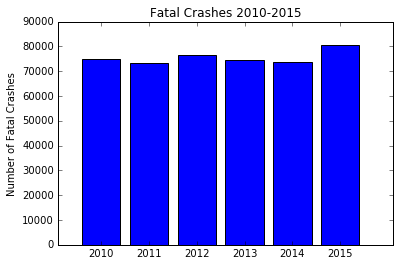

In [17]:
N = len(dfList)
x = np.arange(N)
plt.bar(x+0.5, numFatal)
plt.xticks(x+0.9, ('2010', '2011', '2012', '2013', '2014', '2015'))
plt.ylabel('Number of Fatal Crashes')
plt.title('Fatal Crashes 2010-2015')
plt.show()

2015 appears to have a marked increase in the total number of fatal crashes compared to the previous five years. There has been a roughly linear increase in the US population between 2010-2015, while the number of total crash fatalities has remained approximately the same.

In [18]:
def makeBarChartMean(dfList, feature):
    """Plots of bar chart of means of a qualitative features"""
    totals = []
    N = len(dfList)
    x = np.arange(N)
    for df in dfList:
        df = df[(df[feature] < 998)] #Ignore unknown or NaN values in the dataset
        totals.append(df[feature].mean())
    plt.bar(x+0.5, totals)
    plt.xticks(x+0.9, ('2010', '2011', '2012', '2013', '2014', '2015'))
    plt.ylabel('Mean %s' % feature)
    plt.title('Mean Driver %s 2010-2015' % feature)
    plt.show()

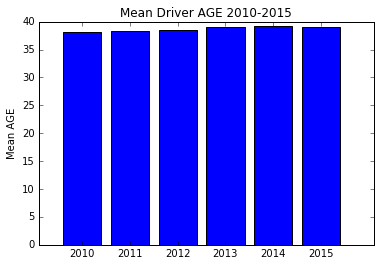

In [19]:
makeBarChartMean(dfList, 'AGE')

Median ages for crash fatalities varied little over the five years. There does however appear to be a slight and fairly consistent increase from 2010 - 2015.

#### Create dataframes for Education, Population, Income, and Unemployment Data.

In [8]:
stateStr = """1 Alabama 31 Nebraska 2 Alaska 32 Nevada 4 Arizona\
            33 New_Hampshire 5 Arkansas 34 New_Jersey 6 California\
            35 New_Mexico 8 Colorado 36 New_York 9 Connecticut\
            37 North_Carolina 10 Delaware 38 North_Dakota 11 District_of_Columbia\
            39 Ohio 12 Florida 40 Oklahoma 13 Georgia 41 Oregon 15 Hawaii\
            42 Pennsylvania 16 Idaho 43 Puerto_Rico 17 Illinois 44 Rhode_Island\
            18 Indiana 45 South_Carolina 19 Iowa 46 South_Dakota 20 Kansas\
            47 Tennessee 21 Kentucky 48 Texas 22 Louisiana 49 Utah 23 Maine\
            50 Vermont 24 Maryland 52 Virgin_Islands 25 Massachusetts\
            51 Virginia 26 Michigan 53 Washington 27 Minnesota 54 West_Virginia\
            28 Mississippi 55 Wisconsin 29 Missouri 56 Wyoming 30 Montana\
            60 American_Samoa 66 Guam 72 Puerto_Rico 78 Virgin_Islands_of_the_U.S.\
            79 Wake_Island
            """
stateList = filter(None,stateStr[:].split(' '))
stateDict = {}
index = 0
while index < len(stateList):
    stateDict[stateList[index]] = stateList[index+1].replace('_', ' ')
    index += 2
print stateDict

{'56': 'Wyoming', '54': 'West Virginia', '51': 'Virginia', '50': 'Vermont', '60': 'American Samoa', '53': 'Washington', '66': 'Guam', '52': 'Virgin Islands', '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota', '20': 'Kansas', '21': 'Kentucky', '48': 'Texas', '49': 'Utah', '46': 'South Dakota', '47': 'Tennessee', '44': 'Rhode Island', '45': 'South Carolina', '42': 'Pennsylvania', '43': 'Puerto Rico', '40': 'Oklahoma', '41': 'Oregon', '1': 'Alabama', '2': 'Alaska', '5': 'Arkansas', '4': 'Arizona', '6': 'California', '9': 'Connecticut', '8': 'Colorado', '28': 'Mississippi', '13': 'Georgia', '12': 'Florida', '72': 'Puerto Rico', '30': 'Montana', '29': 'Missouri', '79': 'Wake Island\n', '78': 'Virgin Islands of the U.S.', '11': 'District of Columbia', '10': 'Delaware', '39': 'Ohio', '38': 'North Dakota', '15': 'Hawaii', '22': 'Louisiana', '17': 'Illinois', '16': 'Idaho', '33': 'New Hampshire', '32': 'Nevada', '31': 'Nebraska', '23': 'Maine', '37': 'North Carolina',

In [9]:
def removeStateAbbr(areaName):
    "Inputs an area name Series and removes State abbreviations, 'County', and 'Municipio'"
    areaNameList = areaName.split(',')
    areaName = areaNameList[0]
    if 'County' in areaName or "Municipio" in areaName:
        areaNameList = areaName.split(' ')
        return areaNameList[0]
    return areaName

In [10]:
education = pd.read_excel('D:/Documents/Jupyter Notebook/2010 - 2015 Crash Fatalities/data/Education.xls', 
                          skiprows=[0,1,2,3])
education = education[education['FIPS Code'] != 0] #Drop row for entire US
columnsToDrop = range(3, len(education.columns)-4) 
education.rename(columns={'Area name': 'Area Name'}, inplace=True)
education = education.drop(education.iloc[:,columnsToDrop], axis=1)
education = education[~education['Area Name'].isin(stateDict.values())] #Remove States
education['Area Name'] = education['Area Name'].map(removeStateAbbr)
education.head()

,FIPS Code,State,Area Name,"Percent of adults with less than a high school diploma, 2011-2015","Percent of adults with a high school diploma only, 2011-2015","Percent of adults completing some college or associate's degree, 2011-2015","Percent of adults with a bachelor's degree or higher, 2011-2015"
2,1001,AL,Autauga,12.8,33.5,30.4,23.2
3,1003,AL,Baldwin,10.5,28.8,31.8,29.0
4,1005,AL,Barbour,26.7,34.5,26.3,12.5
5,1007,AL,Bibb,19.3,42.1,27.9,10.6
6,1009,AL,Blount,21.5,33.4,32.2,12.9


In [11]:
population = pd.read_excel('D:/Documents/Jupyter Notebook/2010 - 2015 Crash Fatalities/data/PopulationEstimates.xls', 
                           skiprows=[0,1])
population = population[population['FIPS'] != 0] #Drop row for entire US
population.rename(columns={'FIPS':'FIPS Code', 'Area_Name': 'Area Name'}, inplace=True)
columnsToDrop = range(8,10) + range(16,len(population.columns)) + [3] + [5] + [8]
population = population.drop(population.iloc[:,columnsToDrop], axis=1)
population = population[~population['Area Name'].isin(stateDict.values())] #Remove States
population['Area Name'] = population['Area Name'].map(removeStateAbbr)
population.head()

,FIPS Code,State,Area Name,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2013,Economic_typology_2015,POP_ESTIMATE_2010,POP_ESTIMATE_2011,POP_ESTIMATE_2012,POP_ESTIMATE_2013,POP_ESTIMATE_2014,POP_ESTIMATE_2015
2,1001,AL,Autauga,2.0,2.0,0.0,54742,55255,55027,54792,54977,55035
3,1003,AL,Baldwin,3.0,2.0,5.0,183199,186653,190403,195147,199745,203690
4,1005,AL,Barbour,6.0,6.0,3.0,27348,27326,27132,26938,26763,26270
5,1007,AL,Bibb,1.0,1.0,0.0,22861,22736,22645,22501,22511,22561
6,1009,AL,Blount,1.0,1.0,0.0,57376,57707,57772,57746,57621,57676


In [12]:
unempIncome = pd.read_excel('D:/Documents/Jupyter Notebook/2010 - 2015 Crash Fatalities/data/Unemployment.xls', 
                            skiprows=[0,1,2,3,4,5,6,7,8])
unempIncome.rename(columns={'FIPStxt':'FIPS Code', 'Area_name': 'Area Name'}, inplace=True)
unempIncome = unempIncome[['FIPS Code', 'State', 'Area Name', 'Unemployment_rate_2010', 'Unemployment_rate_2011',
                          'Unemployment_rate_2012', 'Unemployment_rate_2013', 'Unemployment_rate_2014', 
                           'Unemployment_rate_2015', 'Median_Household_Income_2015']]
unempIncome = unempIncome[~unempIncome['Area Name'].isin(stateDict.values())] #Remove States
unempIncome['Area Name'] = unempIncome['Area Name'].map(removeStateAbbr) #Remove state abbreviations and the word County
unempIncome.head()

,FIPS Code,State,Area Name,Unemployment_rate_2010,Unemployment_rate_2011,Unemployment_rate_2012,Unemployment_rate_2013,Unemployment_rate_2014,Unemployment_rate_2015,Median_Household_Income_2015
1,1001,AL,Autauga,8.9,8.4,6.9,6.2,5.9,5.3,56580.0
2,1003,AL,Baldwin,10.0,9.0,7.5,6.6,6.1,5.6,52387.0
3,1005,AL,Barbour,12.3,11.5,11.5,10.2,10.6,8.8,31433.0
4,1007,AL,Bibb,11.4,10.5,8.5,7.9,7.2,6.7,40767.0
5,1009,AL,Blount,9.8,8.7,6.9,6.3,6.1,5.4,50487.0


In [13]:
# US FIPS Codes for States and Counties XLS File
USFIPS = pd.read_excel('D:/Documents/Jupyter Notebook/2010 - 2015 Crash Fatalities/data/US_FIPS_Codes.xls', 
                            skiprows=[0])
USFIPS.head()

,State,County Name,FIPS State,FIPS County
0,Alabama,Autauga,1,1
1,Alabama,Baldwin,1,3
2,Alabama,Barbour,1,5
3,Alabama,Bibb,1,7
4,Alabama,Blount,1,9


The common thread between the various data sets I am using is the FPIS code: a unique identifier for State and Counties. I need to split the singular FIPS Code for the education, population, and uempIncome dataframes into State and County components to permit merging with the crash dataframes. 

In [26]:
def splitFIPS(FIPSCode):
    "Takes FIPS codes and splits into County and State components"
    FIPSCode = str(FIPSCode)
    if len(FIPSCode) == 4:
        FIPSState = FIPSCode[0]
        FIPSState = int(FIPSState)
        FIPSCounty = FIPSCode[1:]
        FIPSCounty = int(FIPSCounty)
    else: 
        FIPSState = FIPSCode[:2]
        FIPSState = int(FIPSState)
        FIPSCounty = FIPSCode[2:]
        FIPSCounty = int(FIPSCounty)
    return FIPSState, FIPSCounty

In [27]:
def mapFIPSSplit(dfToMod):
    "Maps splitFIPS to dfToMod"
    tempListState = []
    tempListCnty = []
    tempStateDict = {}
    tempCountyDict = {}
    for index, row in dfToMod.iterrows():
        state, county = splitFIPS(row['FIPS Code'])
        tempStateDict[row['FIPS Code']] = state
        tempCountyDict[row['FIPS Code']] = county
    dfToMod['FIPS State'] = dfToMod['FIPS Code'].map(tempStateDict)
    dfToMod['FIPS County'] = dfToMod['FIPS Code'].map(tempCountyDict)

In [28]:
#Split FIPS Codes into State and County components for the dataframes
mapFIPSSplit(unempIncome)
mapFIPSSplit(population)
mapFIPSSplit(education)
# education.tail()
population.head()
# unempIncome.tail()

,FIPS Code,State,Area Name,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2013,Economic_typology_2015,POP_ESTIMATE_2010,POP_ESTIMATE_2011,POP_ESTIMATE_2012,POP_ESTIMATE_2013,POP_ESTIMATE_2014,POP_ESTIMATE_2015,FIPS State,FIPS County
2,1001,AL,Autauga,2.0,2.0,0.0,54742,55255,55027,54792,54977,55035,1,1
3,1003,AL,Baldwin,3.0,2.0,5.0,183199,186653,190403,195147,199745,203690,1,3
4,1005,AL,Barbour,6.0,6.0,3.0,27348,27326,27132,26938,26763,26270,1,5
5,1007,AL,Bibb,1.0,1.0,0.0,22861,22736,22645,22501,22511,22561,1,7
6,1009,AL,Blount,1.0,1.0,0.0,57376,57707,57772,57746,57621,57676,1,9


Now the dataframes can be merged using the FIPS State and FIPS County values. For now I will only focus on the 2015 year data.
First step here is to group the crashes per State and County then determine the size of each group, which represents the number of fatal crashes per County. Then the other features will be merged to the number of crash fatalities per County.

In [29]:
person2015Grouped = person2015.groupby(['STATE', 'COUNTY']).agg('count').reset_index()
person2015Grouped.columns = ['FIPS State', 'FIPS County','Fatal Crashes']
person2015Grouped.head()
print len(person2015Grouped.index)

2851


In [30]:
unempIncome2015 = unempIncome[['Unemployment_rate_2015', 'Median_Household_Income_2015', 
                               'FIPS State', 'FIPS County']]

population2015 = population[['POP_ESTIMATE_2015', 'FIPS State', 'FIPS County', 'State', 'Area Name', 
                             'Rural-urban_Continuum Code_2013', 'Urban_Influence_Code_2013', 'Economic_typology_2015']]

education2015 = education[['Percent of adults with less than a high school diploma, 2011-2015', 
                           "Percent of adults with a high school diploma only, 2011-2015",
                           "Percent of adults completing some college or associate's degree, 2011-2015",
                           "Percent of adults with a bachelor's degree or higher, 2011-2015",
                           'FIPS State', 'FIPS County']]

toMerge = ['FIPS County', 'FIPS State']

frameList = [person2015Grouped, population2015, education2015, unempIncome2015]

#Create a single merged dataframe
final2015 = reduce(lambda left,right: pd.merge(left, right, on=toMerge, how='right'), frameList) 

#Make new column for fatalities per capita
final2015['Fatal Crashes Per Capita'] = final2015['Fatal Crashes'] / final2015['POP_ESTIMATE_2015'] 
final2015.fillna(value=0, inplace=True)
print len(final2015.index)
final2015.head()

3221


,FIPS State,FIPS County,Fatal Crashes,POP_ESTIMATE_2015,State,Area Name,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2013,Economic_typology_2015,"Percent of adults with less than a high school diploma, 2011-2015","Percent of adults with a high school diploma only, 2011-2015","Percent of adults completing some college or associate's degree, 2011-2015","Percent of adults with a bachelor's degree or higher, 2011-2015",Unemployment_rate_2015,Median_Household_Income_2015,Fatal Crashes Per Capita
0,1.0,1.0,17.0,55035.0,AL,Autauga,2.0,2.0,0.0,12.8,33.5,30.4,23.2,5.3,56580.0,0.000309
1,1.0,3.0,85.0,203690.0,AL,Baldwin,3.0,2.0,5.0,10.5,28.8,31.8,29.0,5.6,52387.0,0.000417
2,1.0,5.0,14.0,26270.0,AL,Barbour,6.0,6.0,3.0,26.7,34.5,26.3,12.5,8.8,31433.0,0.000533
3,1.0,7.0,13.0,22561.0,AL,Bibb,1.0,1.0,0.0,19.3,42.1,27.9,10.6,6.7,40767.0,0.000576
4,1.0,9.0,15.0,57676.0,AL,Blount,1.0,1.0,0.0,21.5,33.4,32.2,12.9,5.4,50487.0,0.000260


## Visualization to Find Interesting Correlations

Now that I have a nice clean combined dataframe, I will plot some scatter plots of features versus fatal crashes per capita, then see if any obvious correlations can be found.

In [48]:
def makeScatter(xData, yData, title, xLabel, yLabel, logX=False, logY=False, scale=False):
    if scale:
        xScaled = preprocessing.scale(xData)
        yScaled = preprocessing.scale(yData)
    else:
        xScaled = xData
        yScaled = yData
    if logX and logY:
        xScaled = np.log(xScaled, dtype='float64')
        yScaled = np.log(yScaled, dtype='float64')
    elif logX:
        xScaled = np.log(xScaled, dtype='float64')
    elif logY:
        yScaled = np.log(yScaled, dtype='float64')
    plt.scatter(xScaled, yScaled, alpha=0.5, s=25)
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.show() 

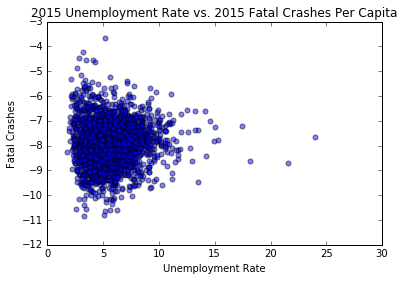

In [49]:
makeScatter(final2015['Unemployment_rate_2015'], final2015['Fatal Crashes Per Capita'],
            '2015 Unemployment Rate vs. 2015 Fatal Crashes Per Capita','Unemployment Rate',
            'Fatal Crashes', logY=True, logX=False)

There does not appear to be a strong correlation between unemployment rate and the number of fatal crashes per capita.

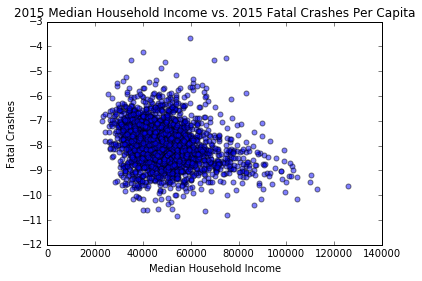

In [50]:
makeScatter(final2015['Median_Household_Income_2015'], final2015['Fatal Crashes Per Capita'],
            '2015 Median Household Income vs. 2015 Fatal Crashes Per Capita','Median Household Income',
            'Fatal Crashes', logY=True, logX=False)

It appears that as median income increases, there is a corresponding decrease in the number of fatal crashes per capita. Could this be caused by wealthier persons purchasing newer and therefore safer vehicles, or better vehicle maintenance?

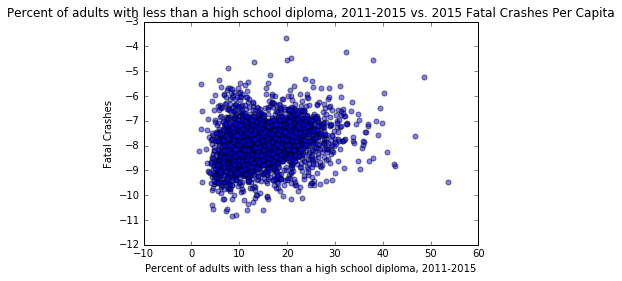

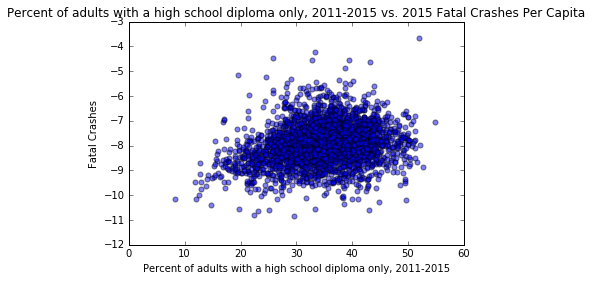

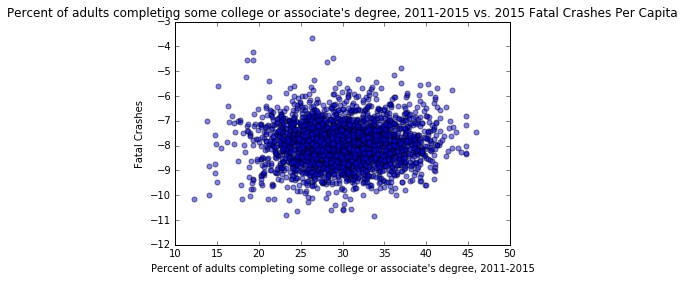

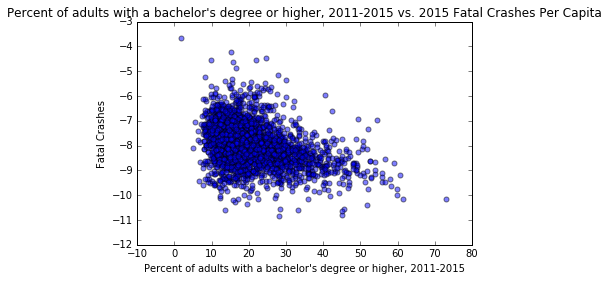

In [51]:
plotList = ['Percent of adults with less than a high school diploma, 2011-2015', 
            "Percent of adults with a high school diploma only, 2011-2015",
            "Percent of adults completing some college or associate's degree, 2011-2015",
            "Percent of adults with a bachelor's degree or higher, 2011-2015"]

for i in plotList:
    makeScatter(final2015[i], final2015['Fatal Crashes Per Capita'],
            '%s vs. 2015 Fatal Crashes Per Capita' % str(i),'%s' % str(i),
            'Fatal Crashes', logY=True, logX=False)


There appears to be a correlation between education level and the number of fatal crashes per capita. As education levels increase, the fatal crashes per capita decreases. Interestingly, completion of just some college or an associate's degree has little effect. 

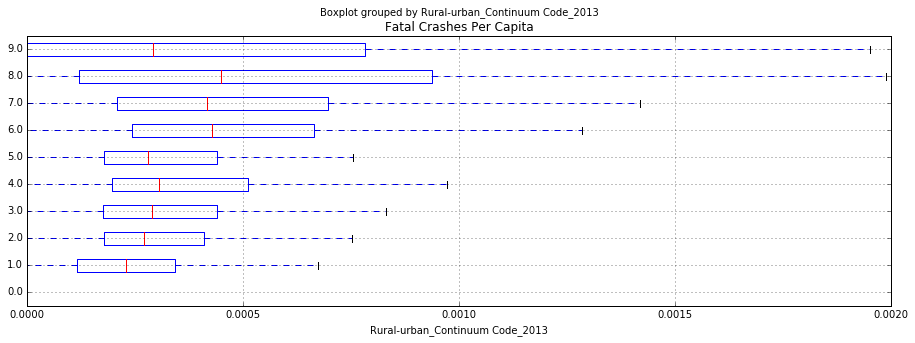

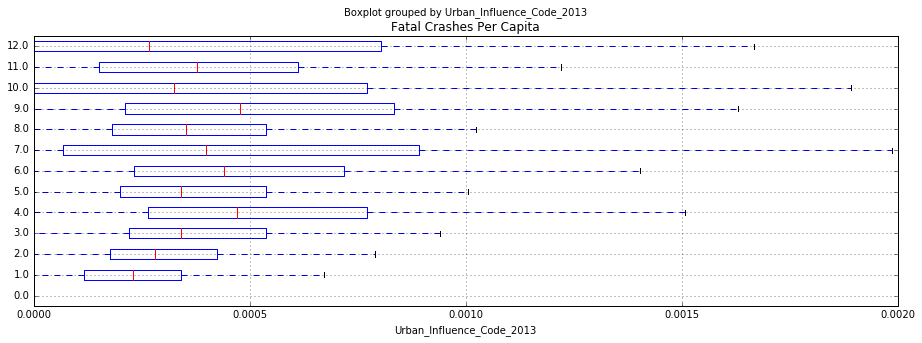

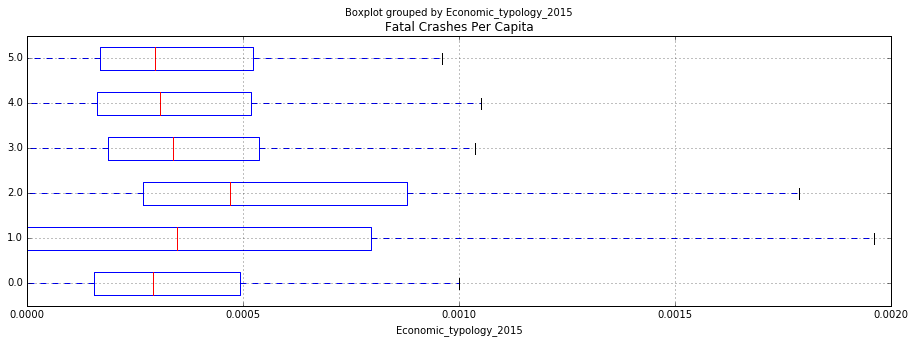

In [84]:
plotList = ['Rural-urban_Continuum Code_2013', 'Urban_Influence_Code_2013', 'Economic_typology_2015']

for i in plotList:                                       
    final2015.boxplot(column='Fatal Crashes Per Capita', by=i, figsize=(15,5), vert=False, showfliers=False)              

The rural-urban continuum codes, urban influence cose, and economic typology do seem to have some relation to fatal crash rates. It is however difficult for me to understand why, since these concepts are nebulous to me. 

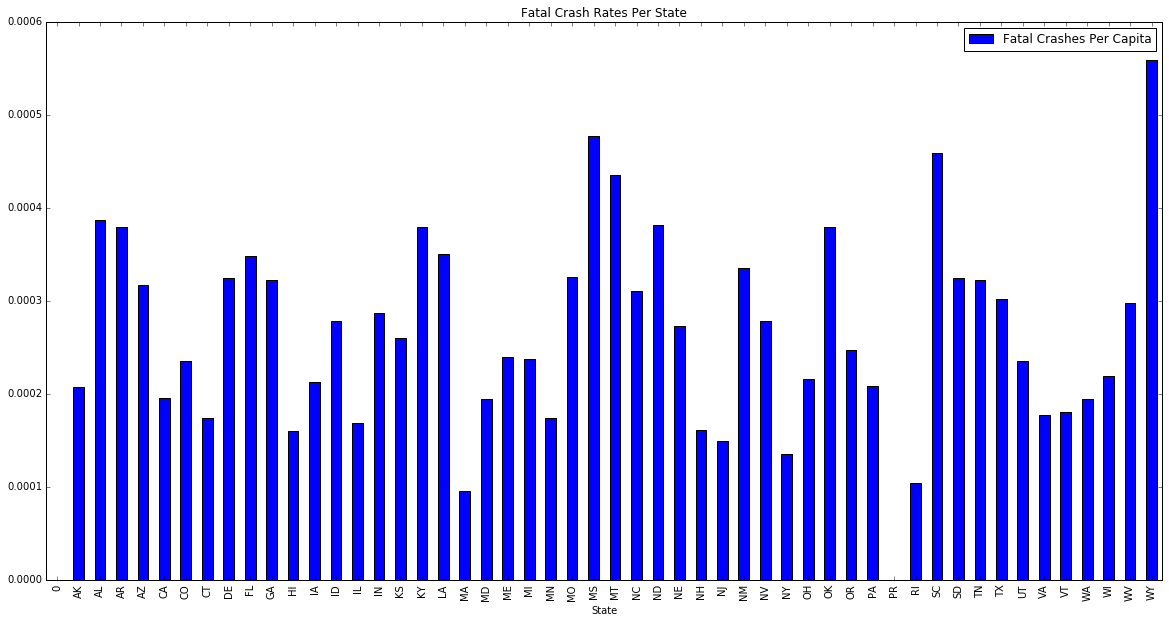

In [85]:
final2015State = final2015.groupby(final2015['State'])[['Fatal Crashes', 'POP_ESTIMATE_2015']].agg(np.sum).reset_index()
final2015State['Fatal Crashes Per Capita'] = final2015State['Fatal Crashes'] / final2015State['POP_ESTIMATE_2015']
final2015State.plot(['State'], ['Fatal Crashes Per Capita'], figsize=(20,10), kind='bar', logy=False, 
                    title='Fatal Crash Rates Per State')
# final2015State

Wyoming, South Carolina, and Mississippi are interesting: very different States in terms of climate and geography but have similar crash fatality rates. Perhaps these States have a high traffic volume of drivers simply passing through, whom are not actually residents. Mississippi and South Carolina have large shipping ports and maybe Wyoming has a high volume of traffic relative to population since it is in between the coasts of the US and hosts US80 and US25. Maybe the rural nature of certain States require residents to drive more often, or result in higher rates of vehicle ownership.

In [86]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

data = json.load(file("D:/Documents/Jupyter Notebook/2010 - 2015 Crash Fatalities/data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(15, 11))
    ax = plt.gca()
    cmap = cm.YlOrRd
    vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    for state in toMap2015State.index:
        if state not in states_abbrev.keys():
            print state
            continue
        color = cmap(norm(states.loc[state]))
        draw_state(ax, states_abbrev[state], color = color, ec='k')
    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

0


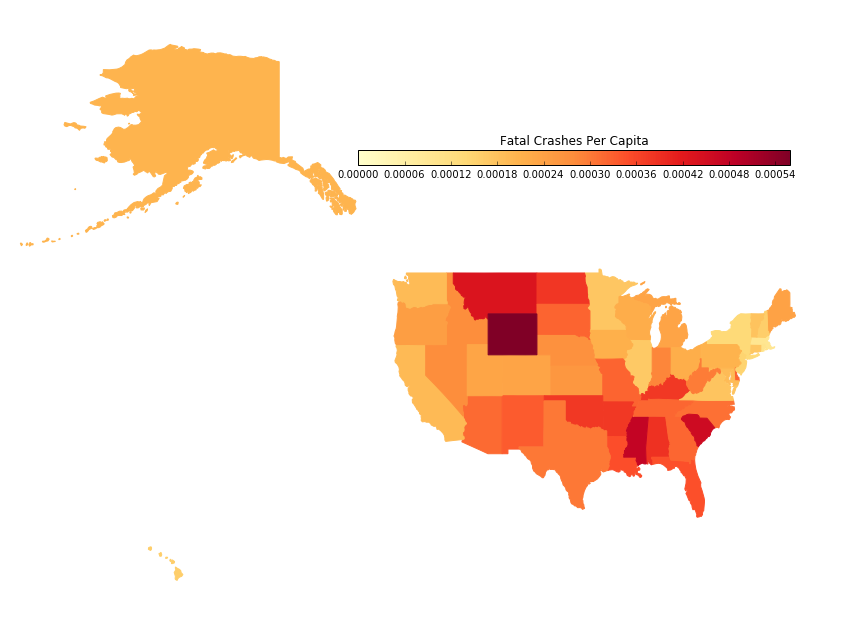

In [87]:
toMap2015State = final2015State[['State','Fatal Crashes Per Capita']].set_index(['State'])
toMap2015State = toMap2015State.drop(['PR'])
make_map(toMap2015State['Fatal Crashes Per Capita'], 'Fatal Crashes Per Capita')

The coastal States have a lower fatal crash rate in general than States in the middle of the US. Also southern States seem to have higher fatal crash rates, with the exception of Montana, Wyoming, and North Dakota.

### Create Regression Model

Now I will create a regression model to see how accurately some of these features can predict fatal crash rates in US Counites. The categorical State, Rural-urban_Continuum Code_2013, Urban_Influence_Code_2013, and Economic_typology_2015 features will be converted using dummy feature encoding.

In [88]:
#Extract predictor features to use
final2015 = final2015[(final2015.State != 0)]#Drop rows with bad State labels
predictorFeats = ['State', 
                  'Percent of adults with less than a high school diploma, 2011-2015', 
                  'Percent of adults with a high school diploma only, 2011-2015',
                  "Percent of adults completing some college or associate's degree, 2011-2015",
                  "Percent of adults with a bachelor's degree or higher, 2011-2015",
                  'Unemployment_rate_2015', 'Rural-urban_Continuum Code_2013', 
                  'Urban_Influence_Code_2013', 'Economic_typology_2015']

X = final2015[[i for i in predictorFeats]]

# Binary encode categorical features
X = pd.get_dummies(X, columns = ['State', 'Rural-urban_Continuum Code_2013', 
                                 'Urban_Influence_Code_2013', 'Economic_typology_2015'])

# Target data
Y = final2015['Fatal Crashes Per Capita']
 
#Support Vector Regression Classifier tuned with Grid Serach CV using liner kernel
SVRLinear = sk.svm.SVR(kernel='linear')
params = {'C': [i+1 for i in range(5,15,1)], 'epsilon': [0.2, 0.3, 0.4, 0.5, 0.6]}
gsSVRLinear = GridSearchCV(SVRLinear, params, cv=5, n_jobs=4)

#Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)
print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

# Standardize data using scaler fit to training data
scaler = sk.preprocessing.StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns)
Y_scaler = scaler.fit(Y_train)
Y_train_scaled = Y_scaler.transform(Y_train)
Y_test_scaled = Y_scaler.transform(Y_test)

# Fit Model
gsSVRLinear.fit(X_train_scaled, Y_train_scaled)

# Assess CV Scores
gsSVRLinear.grid_scores_

(2413, 83)
(805, 83)
(2413L,)
(805L,)


[mean: 0.03586, std: 0.00776, params: {'epsilon': 0.2, 'C': 6},
 mean: 0.04606, std: 0.00598, params: {'epsilon': 0.3, 'C': 6},
 mean: 0.05282, std: 0.00680, params: {'epsilon': 0.4, 'C': 6},
 mean: 0.05574, std: 0.00768, params: {'epsilon': 0.5, 'C': 6},
 mean: 0.05060, std: 0.01350, params: {'epsilon': 0.6, 'C': 6},
 mean: 0.03592, std: 0.00763, params: {'epsilon': 0.2, 'C': 7},
 mean: 0.04612, std: 0.00608, params: {'epsilon': 0.3, 'C': 7},
 mean: 0.05277, std: 0.00652, params: {'epsilon': 0.4, 'C': 7},
 mean: 0.05576, std: 0.00758, params: {'epsilon': 0.5, 'C': 7},
 mean: 0.05060, std: 0.01361, params: {'epsilon': 0.6, 'C': 7},
 mean: 0.03591, std: 0.00779, params: {'epsilon': 0.2, 'C': 8},
 mean: 0.04607, std: 0.00595, params: {'epsilon': 0.3, 'C': 8},
 mean: 0.05276, std: 0.00680, params: {'epsilon': 0.4, 'C': 8},
 mean: 0.05552, std: 0.00798, params: {'epsilon': 0.5, 'C': 8},
 mean: 0.05064, std: 0.01354, params: {'epsilon': 0.6, 'C': 8},
 mean: 0.03588, std: 0.00779, params: {'

In [89]:
gsSVRLinear.best_params_

{'C': 7, 'epsilon': 0.5}

In [90]:
#Test performance of the tunned classifier
score = gsSVRLinear.score(X_test_scaled, Y_test_scaled)
print "Coefficient of Determination =", score

Coefficient of Determination = 0.0255722108361


In [91]:
#Support Vector Regression Classifier tuned with Grid Serach CV using rbf kernel
SVRRBF = sk.svm.SVR(kernel='rbf')
params = {'C': [i+1 for i in range(5,15,1)], 'epsilon': [0.2, 0.3, 0.4, 0.5]}
gsSVRRBF = GridSearchCV(SVRRBF, params, cv=5, n_jobs=4)

# Fit Model
gsSVRRBF.fit(X_train_scaled, Y_train_scaled)

# Assess CV Scores
gsSVRRBF.grid_scores_

[mean: -0.03427, std: 0.12170, params: {'epsilon': 0.2, 'C': 6},
 mean: -0.02524, std: 0.11896, params: {'epsilon': 0.3, 'C': 6},
 mean: -0.01964, std: 0.11515, params: {'epsilon': 0.4, 'C': 6},
 mean: -0.02358, std: 0.12020, params: {'epsilon': 0.5, 'C': 6},
 mean: -0.04273, std: 0.13500, params: {'epsilon': 0.2, 'C': 7},
 mean: -0.03432, std: 0.13131, params: {'epsilon': 0.3, 'C': 7},
 mean: -0.02988, std: 0.12708, params: {'epsilon': 0.4, 'C': 7},
 mean: -0.03386, std: 0.13417, params: {'epsilon': 0.5, 'C': 7},
 mean: -0.05197, std: 0.14827, params: {'epsilon': 0.2, 'C': 8},
 mean: -0.04481, std: 0.14429, params: {'epsilon': 0.3, 'C': 8},
 mean: -0.04075, std: 0.14038, params: {'epsilon': 0.4, 'C': 8},
 mean: -0.04521, std: 0.14967, params: {'epsilon': 0.5, 'C': 8},
 mean: -0.06156, std: 0.16213, params: {'epsilon': 0.2, 'C': 9},
 mean: -0.05597, std: 0.16237, params: {'epsilon': 0.3, 'C': 9},
 mean: -0.05241, std: 0.15904, params: {'epsilon': 0.4, 'C': 9},
 mean: -0.05723, std: 0.1

In [92]:
gsSVRRBF.best_params_

{'C': 6, 'epsilon': 0.4}

In [93]:
#Test performance of the tunned classifier
score = gsSVRRBF.score(X_test_scaled, Y_test_scaled)
print "Coefficient of Determination =", score

Coefficient of Determination = 0.0113984245115


#### SVR Model Conclusion:

Both the linear and RBF kernels provide a poor coefficient of determination, meaning that the model does not replicate the actual crash fatality rate well. This likely means that the features I selected are not highly correlated with the crash fatality rate. Another possibility includes that the model is not well suited for this specific task, or the model parameters are not tuned properly. The model does use education level predictors that are correlated; therefore, the model may benifit from removal of this multicollinearity.

#### Can the initial question be answered?

##### Question: How might improving economic conditions around the country change how Americans are getting around? What models can we develop to identify communities that might be at a higher risk for fatal crashes?

While the regression model failed to provide highly acurate replication of the fatal crash rates, the models did produce coefficients of determination greater than zero, indicating at least some of the fatal crash rate variation can be explaned by the selected features (education levels, rural-urban continuum code, urban influence code, and economic typology). It would however be a strech to claim the models developed here would be useful for identification of higher risk Counties. 

It appears that the most useful takeaway from this analysis is that visualizations uncovered some relation between fatal crash rates, education levels, and income levels; additionally, Wyoming, South Carolina, and Mississippi have notably higher fatal crash rates compared to other States. Education and income levels are generally considered to be correlated, so both having a similar effect on fatal crash rates makes sense. Presuming causation, investing in improving educational attainment in Counties with lower average educational attainment may provide a reduction in the fatal crash rates while also improving economic conditions in said Counties. 